In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

np.random.seed(1337)

In [2]:
data_dict = {}
f = h5py.File("nyu_depth_v2_labeled.mat")
for k, v in tqdm(f.items()):
    data_dict[k] = np.array(v)

  0%|          | 0/14 [00:00<?, ?it/s]

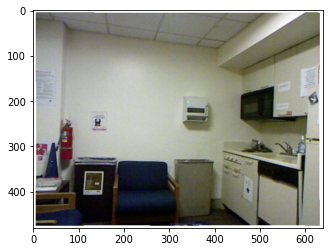

In [3]:
plt.imshow(data_dict['images'][0].transpose((2,1,0)))

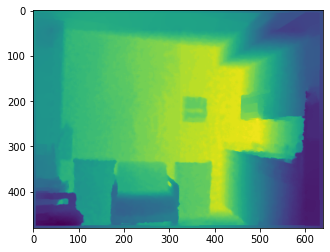

In [4]:
plt.imshow(data_dict['depths'][0].transpose(1,0))


In [5]:
depths = data_dict['depths']
images = data_dict['images']

#Images seem to be rotated 90 degrees. Permute axes to fix rotation
depths = depths.transpose((0, 2, 1))
images = images.transpose((0, 3, 2, 1))

#random shuffle images
shuffle_idx = np.random.permutation(depths.shape[0])
depths = depths[shuffle_idx]
images = images[shuffle_idx]

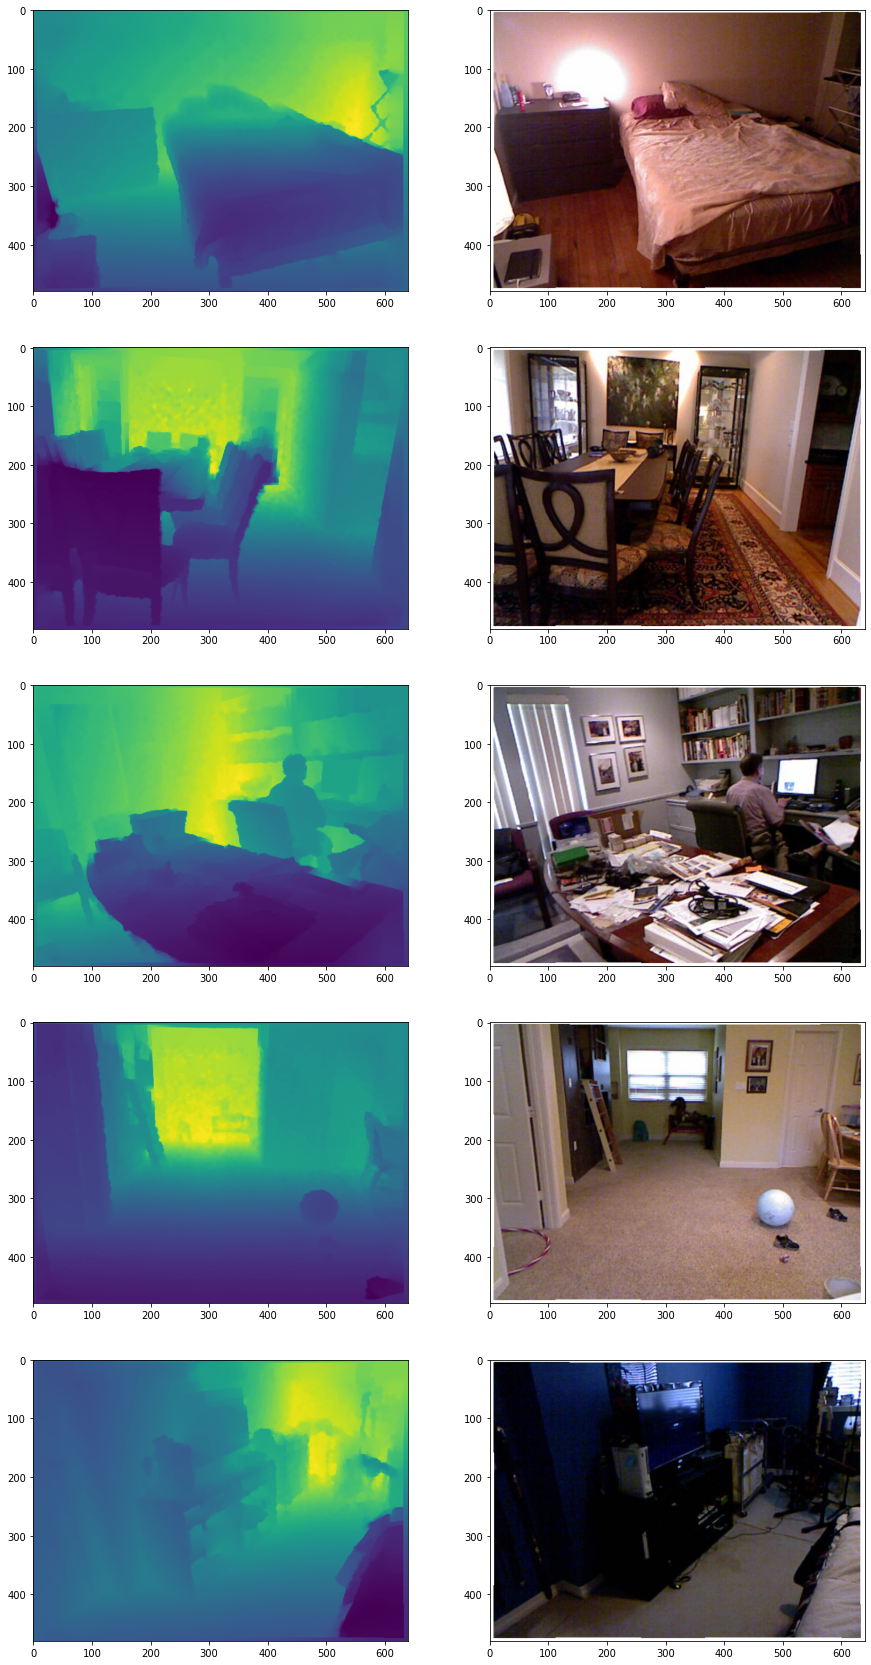

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
for i,ax in enumerate(axes):
    ax[0].imshow(depths[i])
    ax[1].imshow(images[i])

In [7]:
n_samples = depths.shape[0]
n_70 = n_samples * 70 // 100
n_90 = n_samples * 90 // 100

#train
X_train = images[:n_70]
Y_train = depths[:n_70]

#validation
X_val = images[n_70 : n_90]
Y_val = depths[n_70 : n_90]

#test
X_test = images[n_90:]
Y_test = depths[n_90:]

In [8]:
#Save processed data
# X
np.save("x_train.npy", X_train)
np.save("x_val.npy", X_val)
np.save("x_test.npy", X_test)

# Y
np.save("y_train.npy", Y_train)
np.save("y_val.npy", Y_val)
np.save("y_test.npy", Y_test)

In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from unet_model import UNet
#from torchinfo import summary
%matplotlib inline

torch.manual_seed(1337)
np.random.seed(1337)

In [3]:
class MyDataset(Dataset):

    def __init__(self, X_path="x_train.npy", y_path="y_train.npy", transform=None):
        self.X = np.load(X_path).transpose(0, 3, 1, 2)
        self.y = np.load(y_path)
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            sample = self.transform(self.X[idx], self.y[idx])
            return sample, np.expand_dims(self.y[idx], 0)
        else:
            return self.X[idx], np.expand_dims(self.y[idx], 0)
        
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(90),
    transforms.RandomAutocontrast(),
    transforms.ColorJitter()
])

In [4]:
train_dataset = MyDataset("x_train.npy", "y_train.npy")
val_dataset = MyDataset("x_val.npy", "y_val.npy")
test_dataset = MyDataset("x_test.npy", "y_test.npy")

#hyper params
batch_size = 8


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#from models.unet_model_small import UNet
device = "cuda"
model = UNet(3, 1, bilinear=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)

In [6]:
def train(epoch):
    train_loss = 0
    model.train()
    print(f"Running Epoch {epoch}")
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = F.l1_loss(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch} : Avg Loss : {loss}")
    return train_loss
    
        
def validation():
    model.eval()
    validation_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data.float())
        validation_loss += F.l1_loss(output, target).item() # sum up batch loss

    validation_loss /= len(val_loader.dataset)
    print(f'Validation set: Average loss: {validation_loss}')
    return validation_loss

In [7]:
epochs = 100

train_loss = []
validation_loss = []
learning_rate = []

for epoch in range(1, epochs + 1):
    
    loss = train(epoch)
    train_loss.append(loss)
    
    loss = validation()
    validation_loss.append(loss)
    
    
    scheduler.step(loss)
    learning_rate.append(optimizer.param_groups[0]['lr'])
    model_file = 'models/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)

Running Epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1 : Avg Loss : 0.6930012106895447
Validation set: Average loss: 0.13601684467545871
Running Epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2 : Avg Loss : 0.8260620832443237
Validation set: Average loss: 0.13430236598540995
Running Epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3 : Avg Loss : 0.941505491733551
Validation set: Average loss: 0.1327069644270272
Running Epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 4 : Avg Loss : 1.0979156494140625
Validation set: Average loss: 0.14603777712789076
Running Epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 5 : Avg Loss : 1.0293970108032227
Validation set: Average loss: 0.13119925445523756
Running Epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 6 : Avg Loss : 0.9851197004318237
Validation set: Average loss: 0.135161272616222
Running Epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 7 : Avg Loss : 0.9337878823280334
Validation set: Average loss: 0.14598314577135546
Running Epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 8 : Avg Loss : 1.037871241569519
Validation set: Average loss: 0.13084398466965247
Running Epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 9 : Avg Loss : 0.912445604801178
Validation set: Average loss: 0.13446874269123735
Running Epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 10 : Avg Loss : 0.63080894947052
Validation set: Average loss: 0.12639698879472142
Running Epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 11 : Avg Loss : 1.0017460584640503
Validation set: Average loss: 0.12756376204819514
Running Epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 12 : Avg Loss : 0.7560643553733826
Validation set: Average loss: 0.1297749745434728
Running Epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 13 : Avg Loss : 0.6190095543861389
Validation set: Average loss: 0.13082216217600065
Running Epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 14 : Avg Loss : 0.6813676357269287
Validation set: Average loss: 0.1291609745601128
Running Epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 15 : Avg Loss : 0.7066783905029297
Validation set: Average loss: 0.12849242235052175
Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Running Epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 16 : Avg Loss : 0.6976556181907654
Validation set: Average loss: 0.12458873535024709
Running Epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 17 : Avg Loss : 0.893619954586029
Validation set: Average loss: 0.12413149784351217
Running Epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 18 : Avg Loss : 0.8914880752563477
Validation set: Average loss: 0.12392469747313138
Running Epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 19 : Avg Loss : 1.5303645133972168
Validation set: Average loss: 0.12294758558273315
Running Epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 20 : Avg Loss : 0.9163784384727478
Validation set: Average loss: 0.12764318194882623
Running Epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 21 : Avg Loss : 0.7962730526924133
Validation set: Average loss: 0.12332303750103918
Running Epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 22 : Avg Loss : 0.841529905796051
Validation set: Average loss: 0.12008039170298083
Running Epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 23 : Avg Loss : 0.9397663474082947
Validation set: Average loss: 0.11967137435386921
Running Epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 24 : Avg Loss : 0.8823562264442444
Validation set: Average loss: 0.1186979538407819
Running Epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 25 : Avg Loss : 1.0361043214797974
Validation set: Average loss: 0.11746140862333364
Running Epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 26 : Avg Loss : 0.8673852682113647
Validation set: Average loss: 0.11863695814691741
Running Epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 27 : Avg Loss : 0.81318598985672
Validation set: Average loss: 0.11615096782815867
Running Epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 28 : Avg Loss : 1.0472660064697266
Validation set: Average loss: 0.11655822272958427
Running Epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 29 : Avg Loss : 0.7489975094795227
Validation set: Average loss: 0.1145077094949525
Running Epoch 30


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 30 : Avg Loss : 1.0087432861328125
Validation set: Average loss: 0.11485002164182992
Running Epoch 31


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 31 : Avg Loss : 0.9833899140357971
Validation set: Average loss: 0.11422934984338695
Running Epoch 32


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 32 : Avg Loss : 1.0200779438018799
Validation set: Average loss: 0.11452122803392081
Running Epoch 33


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 33 : Avg Loss : 0.6812449097633362
Validation set: Average loss: 0.11303270726368345
Running Epoch 34


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 34 : Avg Loss : 0.9737235903739929
Validation set: Average loss: 0.11410256603668475
Running Epoch 35


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 35 : Avg Loss : 1.3334934711456299
Validation set: Average loss: 0.11651858461314234
Running Epoch 36


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 36 : Avg Loss : 1.0013374090194702
Validation set: Average loss: 0.1149048270850346
Running Epoch 37


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 37 : Avg Loss : 1.043195128440857
Validation set: Average loss: 0.11189182195170172
Running Epoch 38


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 38 : Avg Loss : 1.0497676134109497
Validation set: Average loss: 0.11149251317155773
Running Epoch 39


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 39 : Avg Loss : 1.0458405017852783
Validation set: Average loss: 0.11311174302265561
Running Epoch 40


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 40 : Avg Loss : 0.6756389737129211
Validation set: Average loss: 0.11362679354075728
Running Epoch 41


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 41 : Avg Loss : 0.618349015712738
Validation set: Average loss: 0.12344059142573126
Running Epoch 42


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 42 : Avg Loss : 0.678823709487915
Validation set: Average loss: 0.11477366357014097
Running Epoch 43


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 43 : Avg Loss : 0.5453521609306335
Validation set: Average loss: 0.11449512695444042
Epoch    43: reducing learning rate of group 0 to 1.0000e-05.
Running Epoch 44


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 44 : Avg Loss : 0.6757510304450989
Validation set: Average loss: 0.10737367128503733
Running Epoch 45


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 45 : Avg Loss : 0.7663666605949402
Validation set: Average loss: 0.10769849378487159
Running Epoch 46


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 46 : Avg Loss : 0.7408077716827393
Validation set: Average loss: 0.10675118195599523
Running Epoch 47


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 47 : Avg Loss : 0.597258985042572
Validation set: Average loss: 0.10625776360774862
Running Epoch 48


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 48 : Avg Loss : 0.6731446981430054
Validation set: Average loss: 0.10641735360540193
Running Epoch 49


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 49 : Avg Loss : 0.7573997974395752
Validation set: Average loss: 0.1066792446991493
Running Epoch 50


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 50 : Avg Loss : 0.6727051734924316
Validation set: Average loss: 0.10687482768091662
Running Epoch 51


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 51 : Avg Loss : 0.6435604095458984
Validation set: Average loss: 0.10629385606995945
Running Epoch 52


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 52 : Avg Loss : 0.5709912776947021
Validation set: Average loss: 0.10734301188896442
Epoch    52: reducing learning rate of group 0 to 1.0000e-06.
Running Epoch 53


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 53 : Avg Loss : 0.8191398978233337
Validation set: Average loss: 0.10639439410176771
Running Epoch 54


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 54 : Avg Loss : 0.6571220755577087
Validation set: Average loss: 0.10621681768318703
Running Epoch 55


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 55 : Avg Loss : 0.8273517489433289
Validation set: Average loss: 0.10610761498582774
Running Epoch 56


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 56 : Avg Loss : 0.9558071494102478
Validation set: Average loss: 0.10583581348945355
Running Epoch 57


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 57 : Avg Loss : 0.713783323764801
Validation set: Average loss: 0.10609837791015361
Running Epoch 58


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 58 : Avg Loss : 0.8557518124580383
Validation set: Average loss: 0.10621024493513437
Running Epoch 59


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 59 : Avg Loss : 0.9978590607643127
Validation set: Average loss: 0.10600118328785074
Running Epoch 60


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 60 : Avg Loss : 0.8820981383323669
Validation set: Average loss: 0.106039389248552
Running Epoch 61


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 61 : Avg Loss : 0.9784239530563354
Validation set: Average loss: 0.10638735212128737
Epoch    61: reducing learning rate of group 0 to 1.0000e-07.
Running Epoch 62


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 62 : Avg Loss : 0.7567209601402283
Validation set: Average loss: 0.10585331793489128
Running Epoch 63


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 63 : Avg Loss : 0.6480538249015808
Validation set: Average loss: 0.10616804464110012
Running Epoch 64


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 64 : Avg Loss : 0.7072345018386841
Validation set: Average loss: 0.1059299637531412
Running Epoch 65


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 65 : Avg Loss : 0.6441748142242432
Validation set: Average loss: 0.1059805179464406
Running Epoch 66


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 66 : Avg Loss : 0.6760598421096802
Validation set: Average loss: 0.10597532453208135
Epoch    66: reducing learning rate of group 0 to 1.0000e-08.
Running Epoch 67


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 67 : Avg Loss : 1.028579592704773
Validation set: Average loss: 0.10612687838488612
Running Epoch 68


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 68 : Avg Loss : 0.8074260950088501
Validation set: Average loss: 0.10584287170706125
Running Epoch 69


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 69 : Avg Loss : 0.6306334733963013
Validation set: Average loss: 0.10613267997215534
Running Epoch 70


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 70 : Avg Loss : 0.8313798308372498
Validation set: Average loss: 0.10592991606942538
Running Epoch 71


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 71 : Avg Loss : 0.8634209036827087
Validation set: Average loss: 0.10591318134603829
Running Epoch 72


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 72 : Avg Loss : 0.5948759913444519
Validation set: Average loss: 0.10609094747181597
Running Epoch 73


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 73 : Avg Loss : 0.7642970085144043
Validation set: Average loss: 0.10587145357296385
Running Epoch 74


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 74 : Avg Loss : 0.9454604387283325
Validation set: Average loss: 0.1058638217120335
Running Epoch 75


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 75 : Avg Loss : 0.7709172964096069
Validation set: Average loss: 0.10576261878013611
Running Epoch 76


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 76 : Avg Loss : 0.6111595630645752
Validation set: Average loss: 0.10590482148630866
Running Epoch 77


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 77 : Avg Loss : 0.7013469934463501
Validation set: Average loss: 0.10598416266770198
Running Epoch 78


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 78 : Avg Loss : 0.7804576754570007
Validation set: Average loss: 0.10611510687860949
Running Epoch 79


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 79 : Avg Loss : 0.8592867255210876
Validation set: Average loss: 0.10596156695793416
Running Epoch 80


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 80 : Avg Loss : 0.6711453795433044
Validation set: Average loss: 0.10579053677361587
Running Epoch 81


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 81 : Avg Loss : 0.719204843044281
Validation set: Average loss: 0.1058495961386582
Running Epoch 82


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 82 : Avg Loss : 0.864241898059845
Validation set: Average loss: 0.10609431883384442
Running Epoch 83


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 83 : Avg Loss : 0.5689025521278381
Validation set: Average loss: 0.10584885724659623
Running Epoch 84


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 84 : Avg Loss : 0.6943201422691345
Validation set: Average loss: 0.10594721600927155
Running Epoch 85


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 85 : Avg Loss : 0.9157466292381287
Validation set: Average loss: 0.105951530357887
Running Epoch 86


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 86 : Avg Loss : 0.6407662034034729
Validation set: Average loss: 0.10605725337719095
Running Epoch 87


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 87 : Avg Loss : 0.7707691192626953
Validation set: Average loss: 0.10628930556363073
Running Epoch 88


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 88 : Avg Loss : 1.1888172626495361
Validation set: Average loss: 0.10614636519859577
Running Epoch 89


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 89 : Avg Loss : 0.9380098581314087
Validation set: Average loss: 0.1058665287905726
Running Epoch 90


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 90 : Avg Loss : 0.8095679879188538
Validation set: Average loss: 0.10579282271450964
Running Epoch 91


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 91 : Avg Loss : 1.0185925960540771
Validation set: Average loss: 0.10642303947744698
Running Epoch 92


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 92 : Avg Loss : 0.6324863433837891
Validation set: Average loss: 0.1062791407108307
Running Epoch 93


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 93 : Avg Loss : 0.7725002765655518
Validation set: Average loss: 0.10610302604477981
Running Epoch 94


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 94 : Avg Loss : 0.6535558700561523
Validation set: Average loss: 0.1062453280235159
Running Epoch 95


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 95 : Avg Loss : 0.7863097190856934
Validation set: Average loss: 0.10618446551520248
Running Epoch 96


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 96 : Avg Loss : 0.7351600527763367
Validation set: Average loss: 0.10626317139329582
Running Epoch 97


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 97 : Avg Loss : 0.5967916250228882
Validation set: Average loss: 0.1058278725065034
Running Epoch 98


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 98 : Avg Loss : 0.6722813248634338
Validation set: Average loss: 0.10611194474943753
Running Epoch 99


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 99 : Avg Loss : 0.6531715393066406
Validation set: Average loss: 0.10625802237412026
Running Epoch 100


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 100 : Avg Loss : 0.8043771982192993
Validation set: Average loss: 0.10581147465212591


In [13]:
test_dataset = MyDataset("x_test.npy", "y_test.npy")

batch_size = 1

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
device = "cuda"
model = UNet(3, 1, bilinear=False)

model.load_state_dict(torch.load("models/model_98.pth"))

model = model.to(device)

In [15]:
def test():
    images, predictions, ground_truths = [], [], []
    model.eval()
    test_loss = 0
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data.float())
        test_loss += F.l1_loss(output, target).item() # sum up batch loss
        images.append(data.detach().cpu())
        predictions.append(output.detach().cpu())
        ground_truths.append(target.detach().cpu())

    test_loss /= len(test_loader.dataset)
    print(f'test set: Average loss: {test_loss}')
    
    return images, predictions, ground_truths
    
images, predictions, ground_truths = test()

  0%|          | 0/145 [00:00<?, ?it/s]

test set: Average loss: 0.909429204669492


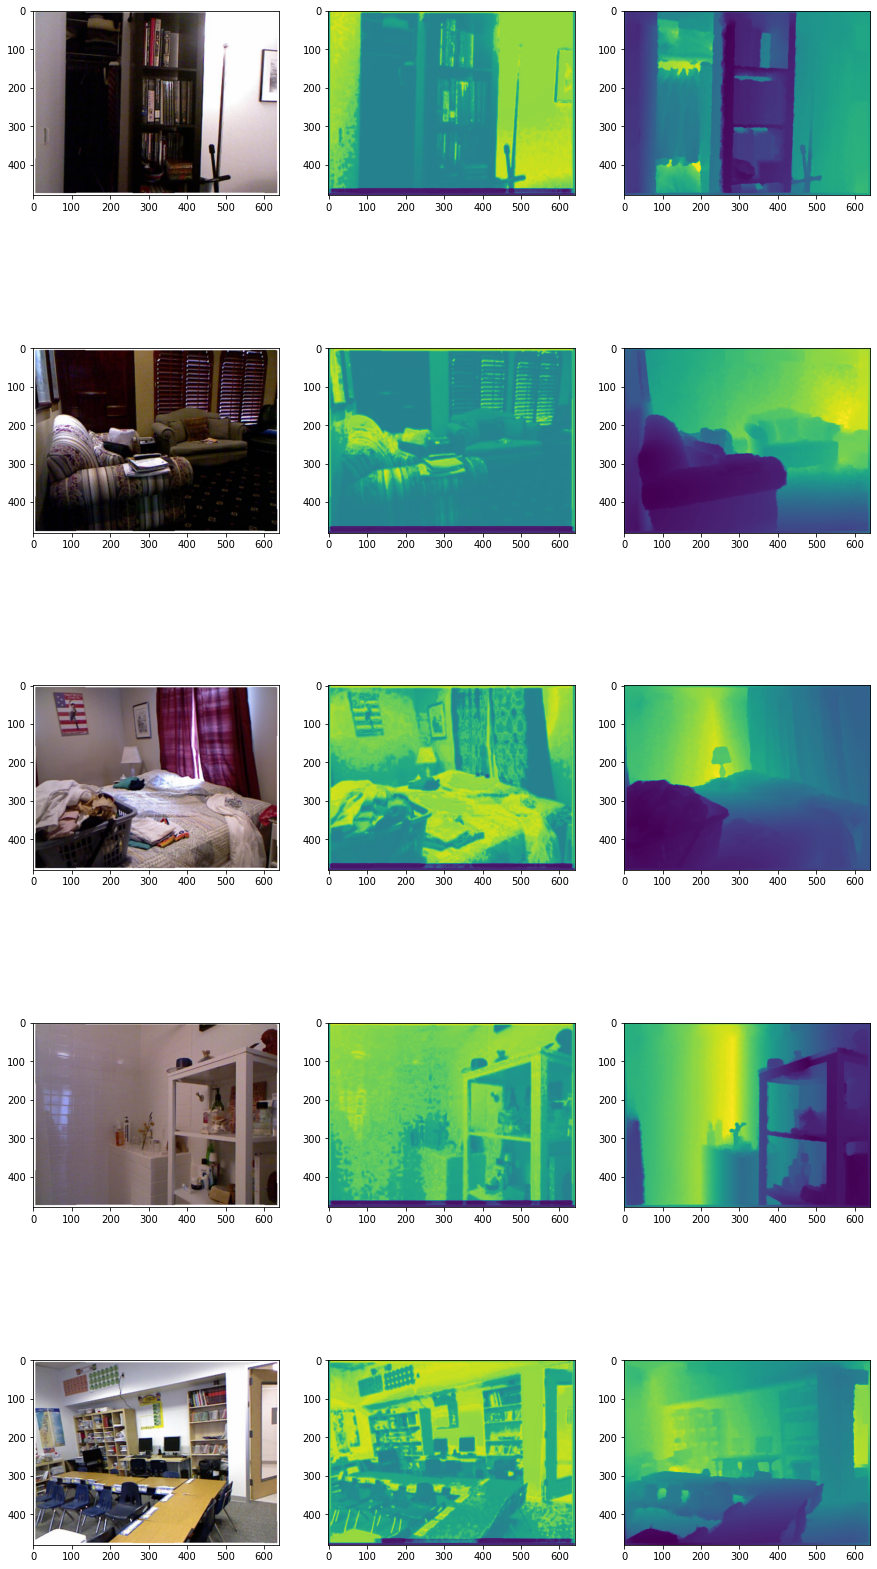

In [11]:
fig, axes = plt.subplots(5, 3, figsize=(15, 30))
for i,ax in enumerate(axes):
    image = np.squeeze(images[i])
    pred = np.squeeze(predictions[i])
    ground_truth = np.squeeze(ground_truths[i])
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(pred)
    ax[2].imshow(ground_truth)